In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('../../../non_corrupt_starclass/starclass')
#sys.path.append('../../../shap/')

In [3]:
from matplotlib import rc
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

In [4]:
import matplotlib.pyplot as plt

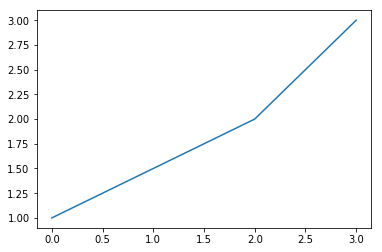

In [5]:
plt.plot([0,2,3], [1,2,3])

In [6]:
import numpy as np
import pandas as pd
import pickle
import sqlite3
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import shap
shap.initjs()

In [7]:
connection = sqlite3.connect('../starclass/training_sets/data/keplerq9/todo.sqlite')

In [8]:
df = pd.read_sql_query("select * from starclass;", connection)
labels = pd.read_sql_query("select * from diagnostics;", connection)
labels['label'] = [i.split('/')[0] for i in labels['lightcurve'].values]
print(df.head(10))
connection.close()

   priority classifier  status          class  prob
0       892       rfgc       1  RRLYR_CEPHEID   0.0
1       892       rfgc       1      APERIODIC   0.0
2       892       rfgc       1       CONSTANT   1.0
3       892       rfgc       1    CONTACT_ROT   0.0
4       892       rfgc       1      DSCT_BCEP   0.0
5       892       rfgc       1       GDOR_SPB   0.0
6       892       rfgc       1      SOLARLIKE   0.0
7       892       rfgc       1        ECLIPSE   0.0
8       895       rfgc       1  RRLYR_CEPHEID   0.0
9       895       rfgc       1      APERIODIC   0.0


In [9]:
y = labels['label'].values[df['priority'].unique()-1].astype('U15')
y[y == 'APERIODIC'] = 'aperiodic'
y[y == 'CONSTANT'] = 'constant'
y[y == 'RRLYR_CEPHEID'] = 'RRLyr/Ceph'
y[y == 'CONTACT_ROT'] = 'contactEB/spots'
y[y == 'DSCT_BCEP'] = 'dSct/bCep'
y[y == 'ECLIPSE'] = 'transit/eclipse'
y[y == 'GDOR_SPB'] = 'gDor/spB'
y[y == 'SOLARLIKE'] = 'solar'

In [10]:
rfgc = df.loc[(df['classifier'] == 'rfgc'), 'prob'].values.reshape(len(df)//32, 8)
slosh = df.loc[(df['classifier'] == 'slosh'), 'prob'].values.reshape(len(df)//32, 8)
xgb = df.loc[(df['classifier'] == 'xgb'), 'prob'].values.reshape(len(df)//32, 8)

In [11]:
feature_names = ['rfgc_RRLYR_CEPHEID', 'rfgc_APERIODIC', 'rfgc_CONSTANT', 
                 'rfgc_CONTACT_ROT', 'rfgc_DSCT_BCEP', 'rfgc_GDOR_SPB', 
                 'rfgc_SOLARLIKE', 'rfgc_ECLIPSE',
                 'slosh_RRLYR_CEPHEID', 'slosh_APERIODIC', 'slosh_CONSTANT', 
                 'slosh_CONTACT_ROT', 'slosh_DSCT_BCEP', 'slosh_GDOR_SPB', 
                 'slosh_SOLARLIKE', 'slosh_ECLIPSE',
                 'xgb_RRLYR_CEPHEID', 'xgb_APERIODIC', 'xgb_CONSTANT', 
                 'xgb_CONTACT_ROT', 'xgb_DSCT_BCEP', 'xgb_GDOR_SPB', 
                 'xgb_SOLARLIKE', 'xgb_ECLIPSE',]
class_names = ['RRLYR_CEPHEID', 'APERIODIC', 'CONSTANT', 
                      'CONTACT_ROT', 'DSCT_BCEP', 'GDOR_SPB', 
                      'SOLARLIKE', 'ECLIPSE']

In [12]:
features = np.c_[rfgc, slosh, xgb]
print(features.shape)

(5755, 24)


In [21]:
#with open('../starclass/data/L1/keplerq9/meta_fold01/rfgc_classifier_v01.pickle', 'rb') as pickle_file:
#with open('../starclass/data/L1/keplerq9/meta_fold01/meta_classifier.pickle', 'rb') as pickle_file:
#    model = pickle.load(pickle_file)
with open('../starclass/data/L1/keplerq9/meta_classifier.pickle', 'rb') as pickle_file:
    model = pickle.load(pickle_file)
    
#model = pickle.load('../starclass/data/L1/keplerq9/meta_fold01/rfgc_classifier_v01.pickle')

In [22]:
model.feature_importances_

array([0.0140362 , 0.07707195, 0.07844864, 0.00301205, 0.07233608,
       0.02975136, 0.03614547, 0.03259802, 0.05403535, 0.04489035,
       0.01359305, 0.00985403, 0.03981064, 0.05034858, 0.02942018,
       0.04135287, 0.01014   , 0.03356039, 0.06721911, 0.0364562 ,
       0.07601513, 0.04352528, 0.01515278, 0.09122629])

In [23]:
str(type(model))

"<class 'starclass.MetaClassifier.Meta.Classifier_obj'>"

In [24]:
model.n_features_

24

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, y, 
                                                    test_size=0.1, random_state=42)

In [26]:
#model.fit(X_train, y_train)

In [27]:
preds = model.predict(X_test)

In [28]:
accuracy_score(preds, y_test)

0.5746527777777778

In [43]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

starclass


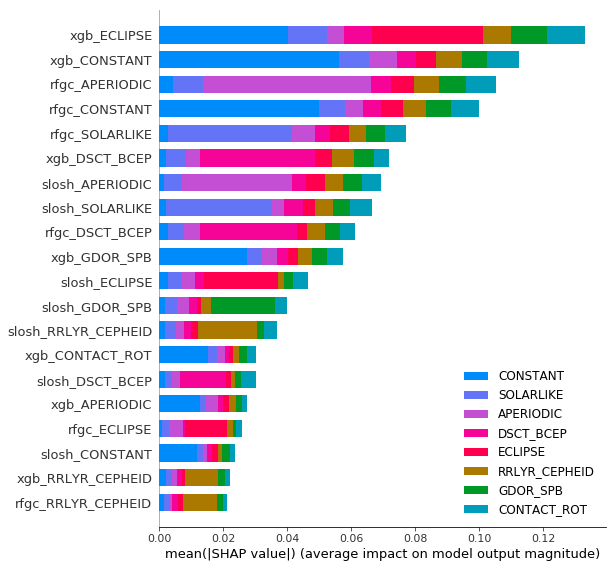

In [44]:
fig = shap.summary_plot(shap_values, X_test, 
                  feature_names=feature_names,
                  class_names=class_names)

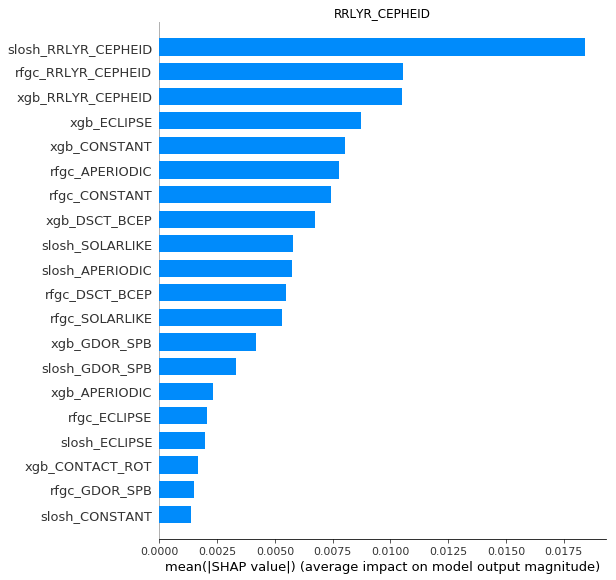

<Figure size 432x288 with 0 Axes>

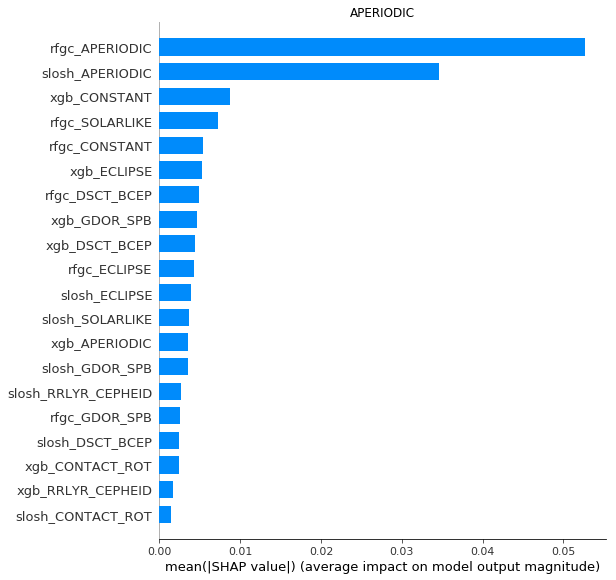

<Figure size 432x288 with 0 Axes>

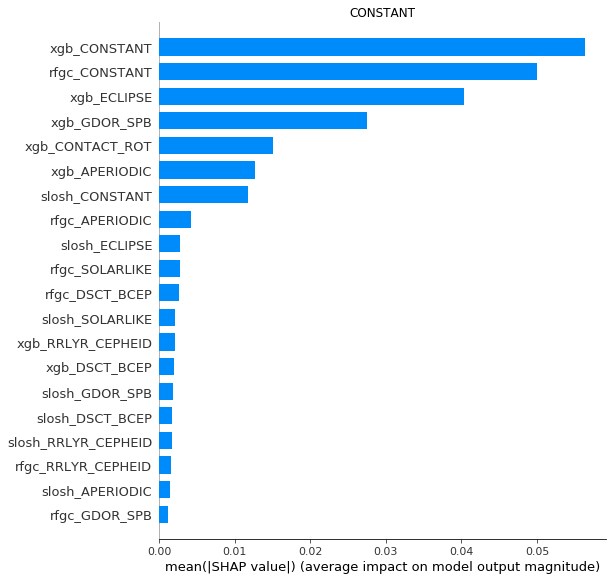

<Figure size 432x288 with 0 Axes>

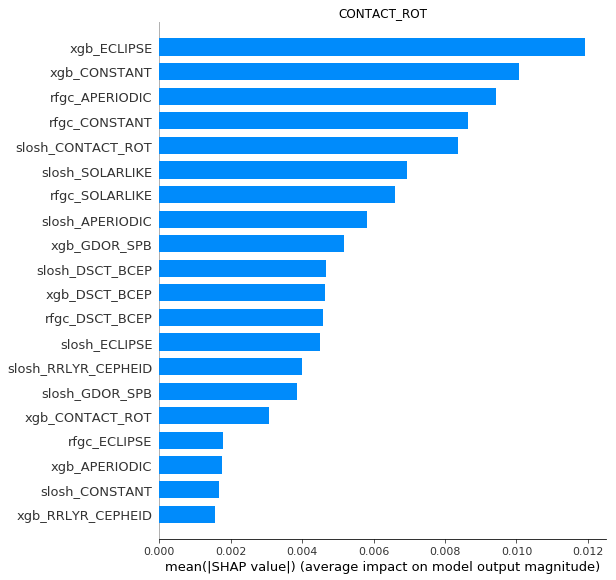

<Figure size 432x288 with 0 Axes>

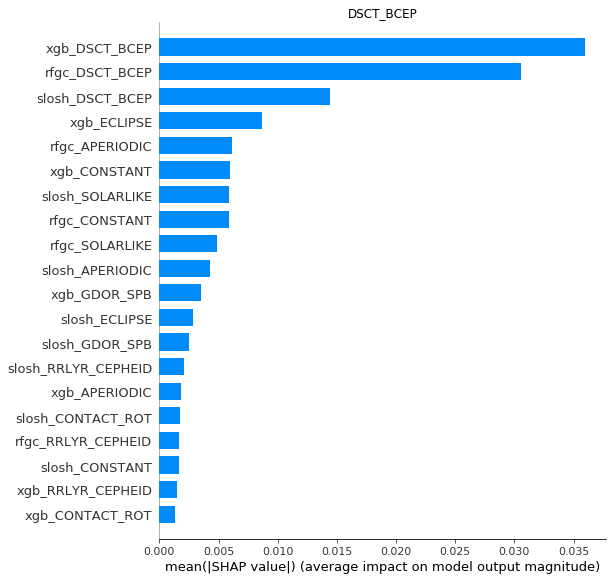

<Figure size 432x288 with 0 Axes>

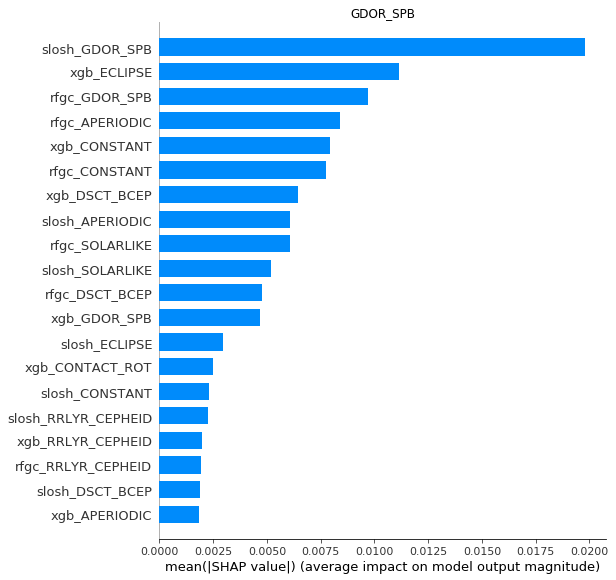

<Figure size 432x288 with 0 Axes>

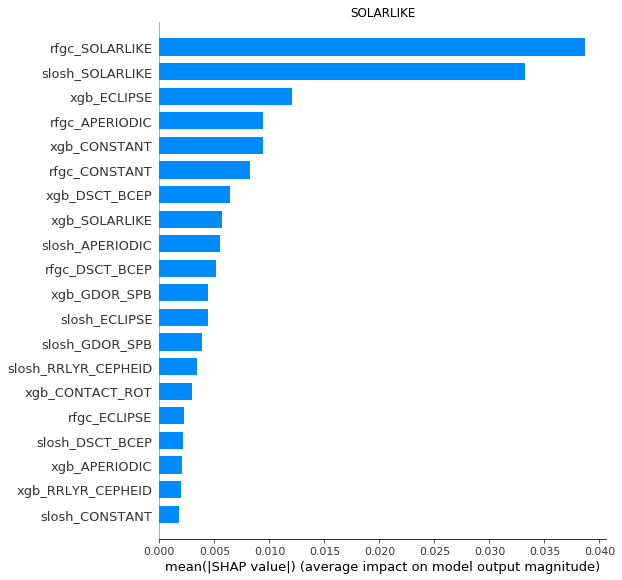

<Figure size 432x288 with 0 Axes>

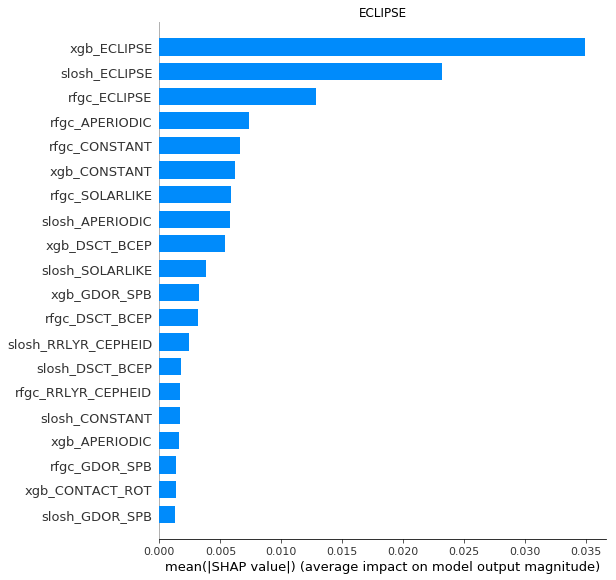

<Figure size 432x288 with 0 Axes>

In [45]:
for i in range(len(class_names)):
    plt.figure(i)
    plt.title(class_names[i])
    shap.summary_plot(shap_values[i], X_test, 
                      feature_names=feature_names,
                      class_names=class_names[i], plot_type="bar")
    plt.savefig(class_names[i]+'.png', bbox_inches='tight')
    plt.show()